In [9]:
import matplotlib.pyplot as plt
import networkx as nx

{('a', 'b'): 0.5}


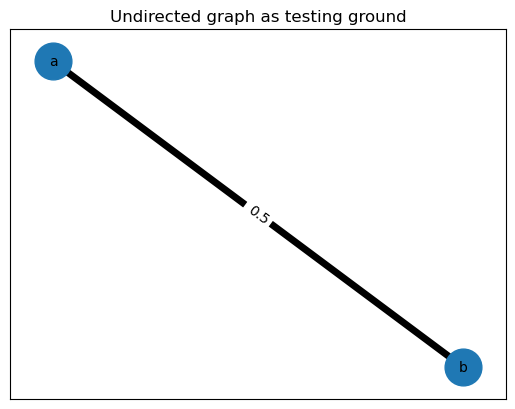

In [10]:
graph = nx.Graph()

# graph wird als kantenliste gespeichert
graph.add_edge("a", "b", weight = 0.5)
graph.add_edge("b", "a", weight = 0.5)

# positionen der knoten wird jedesmal neu bestimmt, ausser wir legen seed fest
pos = nx.spring_layout(graph, seed = 7)

# zeichne nodes
nx.draw_networkx_nodes(graph, pos, node_size=700)

# zeichne edges
nx.draw_networkx_edges(graph, pos, width=5)

# zeichne knotennamen
nx.draw_networkx_labels(graph, pos, font_size=10)

# zeichne kantengewichte
edge_labels = nx.get_edge_attributes(graph, "weight")
print(edge_labels)
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

plt.title("Undirected graph as testing ground")
plt.show()

#### MaxFlow problem instances always give a directed graph
practice visualizing directed graphs

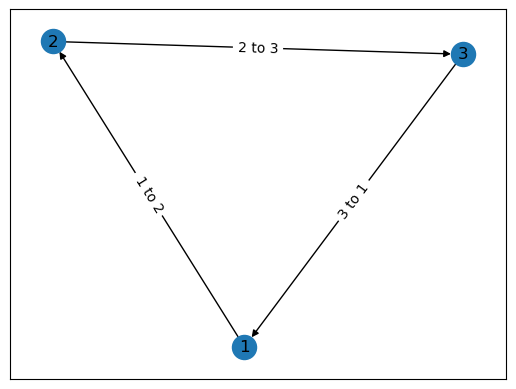

In [11]:
diGraph = nx.DiGraph()

diGraph.add_nodes_from([1, 2, 3])
diGraph.add_edges_from([(1,2), (2,3), (3, 1)])

# das ist immer ein dictionary, welches edges auf namen abbildet
edge_labels = {(1,2): "1 to 2", (2,3): "2 to 3", (3,1): "3 to 1"}

diGraphPos = nx.spring_layout(diGraph, seed = 7)

nx.draw_networkx(diGraph, pos=diGraphPos)
nx.draw_networkx_edge_labels(diGraph, pos=diGraphPos, edge_labels=edge_labels)
plt.show()

Plan fuer Ford-Fulkerson
- [X] Baue Datenstruktur FlowGraph, die Kantenliste und Kapazitaeten nimmt
- [X] Baue Visualisierungsfunktion vom Flowgraph
- [X] Erstelle Residualgraph und visualisiere
- [X] Finde gerichteten Pfad von Start zu Zielknoten im Residualgraph
5. Augmente Flow solange bis es keinen gerichteten Pfad mehr gibt
6. gib ideale Loesung aus

In [84]:
import itertools

# to make reproducable
seed = 7

class FlowGraph:
    
    # edge_list = [(from string, to_string, capacity)]
    def __init__(self, edge_list, start, end):
        
        # capacity and flow as functions / dictionaries
        self.capacities = {(from_node, to_node) : capacity for (from_node, to_node, capacity) in edge_list}
        self.flow = {(from_node, to_node) : 0 for (from_node, to_node, capacity) in edge_list}
        
        self.nodes = [[edge[0], edge[1]] for edge in edge_list]
        #flatten
        self.nodes = list(itertools.chain(*self.nodes))
        #distinct
        self.nodes = list(set(self.nodes))
        
        self.edges = [(from_node, to_node) for (from_node, to_node, capacity) in edge_list]
        
        self.res_edges = []
        # flow thats left over (until max capacity or until zero)
        self.res_flow = dict()
        
        self.start = start
        self.end = end
        
        self.graph = nx.DiGraph()
        self.graph.add_nodes_from(self.nodes)
        self.graph.add_edges_from(self.edges)
        
        self.res_graph = nx.DiGraph()
        self.res_graph.add_nodes_from(self.nodes)
        self.res_graph.add_edges_from(self.res_edges)
        self.update_res_graph()
        
        self.color_map = []
        for node in self.graph:
            if node == start:
                self.color_map.append("green")
            elif node == end:
                self.color_map.append("red")
            else:
                self.color_map.append("lightblue")
        
        self.graphPos = nx.spring_layout(self.graph, seed = seed)
        
    def draw_flow_graph(self):
        plt.title("Flow graph")
        nx.draw_networkx(self.graph, self.graphPos, node_color=self.color_map)
        
        # build up edge labels on the fly
        edge_labels = dict()
        
        for edge in self.edges:
            edge_labels[edge] = str(self.flow[edge]) + "/" + str(self.capacities[edge])
            
        nx.draw_networkx_edge_labels(self.graph, self.graphPos, edge_labels=edge_labels)
        plt.show()
        
    def draw_res_graph(self):
                
        plt.title("Residual graph")
        nx.draw_networkx(self.res_graph, self.graphPos, node_color=self.color_map)
        nx.draw_networkx_edge_labels(self.res_graph, self.graphPos, edge_labels=self.res_flow)
        plt.show()
        
    
    # assume that 0 <= f <= c
    def update_res_graph(self):
        
        new_res_edges = []
        
        for (from_node, to_node) in self.edges:
            f = self.flow[(from_node, to_node)]
            c = self.capacities[(from_node, to_node)]
            self.res_flow[(from_node, to_node)] = c - f if f < c else f
            
            if f < c:
                new_res_edges.append((from_node, to_node))
                
            else:
                new_res_edges.append((to_node, from_node))
                
        # remove all old edges
        for edge in self.res_edges:
            self.res_graph.remove_edge(*edge)
        
        # add all new edges
        self.res_graph.add_edges_from(new_res_edges)
            
        self.res_edges = new_res_edges
    
    # find path using BFS
    def find_path(self):
        
        visited = set()
        # stores parents
        comes_from = {self.start : None}
        
        queue = [self.start]
        found_path = False
        
        while len(queue) > 0:
            
            curr = queue.pop(0)
            
            if curr == self.end:
                found_path = True
                break
                
            visited.add(curr)
                
            for (from_node, to_node) in self.res_edges:
                if from_node == curr and to_node not in visited:
                    queue.append(to_node)
                    comes_from[to_node] = from_node
                    
        if not found_path:
            return []
        
        # reconstruct path
        curr = self.end
        path = []
        
        while curr is not None:
            path.insert(0, curr)
            curr = comes_from[curr]
            
        return path
    
    def solve(self):
        # TODO
        pass
                    

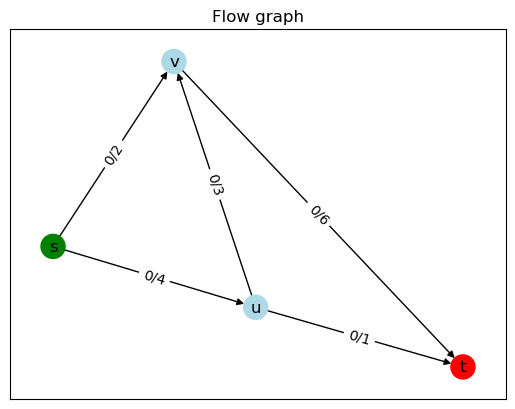

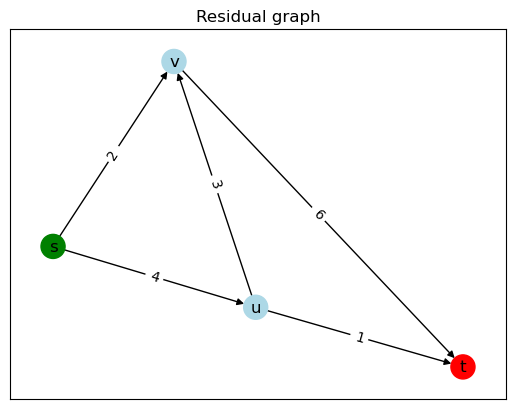

['s', 'u', 'v', 't']


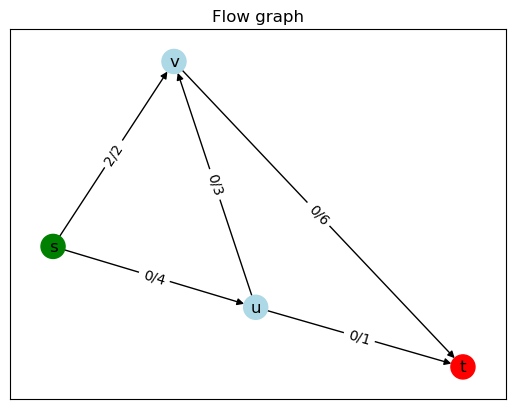

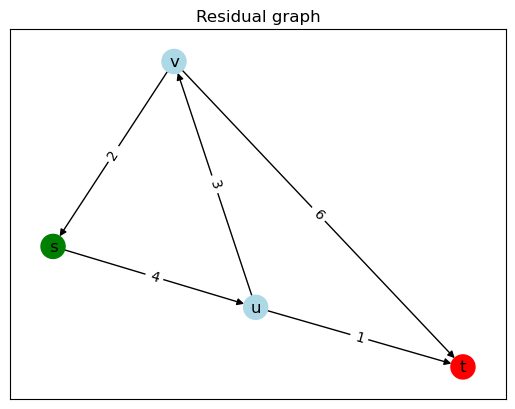

['s', 'u', 'v', 't']


In [85]:
# Wikipedia example
# https://de.wikipedia.org/wiki/Algorithmus_von_Ford_und_Fulkerson
edge_list = [("s", "u", 4), ("s", "v", 2), ("u", "v", 3), ("u", "t", 1), ("v", "t", 6)]

flowGraph = FlowGraph(edge_list = edge_list, start="s", end="t")
flowGraph.draw_flow_graph()
flowGraph.draw_res_graph()

path = flowGraph.find_path()
print(path)

flowGraph.flow[("s", "v")] = 2
flowGraph.draw_flow_graph()

flowGraph.update_res_graph()
flowGraph.draw_res_graph()

path = flowGraph.find_path()
print(path)